# Aula 06 - Regressão Linear Múltipla pt2

O objetivo desta aula é melhorar nosso modelo de Regressão Linear Múltipla que começamos semana passada.

O primeiro conceito que introduziremos é a remoção de variáveis que não acrescentam na performance do modelo. Nem sempre mais variáveis é melhor. Algumas não vão ajudar e podem simplesmente "poluir" o modelo. Vamos aprender a identificar essas variáveis e removê-las.

Vamos explorar o método de backwards-elimination. Basicamente é quando começamos com todas as variáveis e vamos cortando-as aos poucos do modelo.

Como da última vez, vamos iniciar com as nossas funções de pré-processamento.

In [1]:
import numpy as np
import pandas as pd

def loadDataset(filename):
    baseDeDados = pd.read_csv(filename, delimiter=';')
    X = baseDeDados.iloc[:,:-1].values
    y = baseDeDados.iloc[:,-1].values
    return X, y

def fillMissingData(X, inicioColuna, fimColuna):
    from sklearn.impute import SimpleImputer
    imputer = SimpleImputer(missing_values=np.nan, strategy='median')
    X[:,inicioColuna:fimColuna + 1] = imputer.fit_transform(X[:,inicioColuna:fimColuna + 1])
    return X

# só funciona se i = 0 ou i = ultima coluna
def computeCategorization(X, i):
    
    from sklearn.preprocessing import LabelEncoder
    labelencoder_X = LabelEncoder()
    X[:, i] = labelencoder_X.fit_transform(X[:, i])

    #one hot encoding
    D = pd.get_dummies(X[:,i]).values #Cria dummies para os valores únicos encontrados na coluna i da matriz X
    if(i == 0):
        X = X[:,1:]
        X = np.insert(X, 0, D, axis=1)
        #removendo dummy variable trap
        X = X[:,1:]
    else:
        X = X[:,:i]
        for j in range(0, D.shape[1]): #Para cada coluna da matriz D vai inserindo uma a uma ao final de X.
            X = np.insert(X, i, D[:,j], axis=1)
        #removendo dummy variable trap
        X = X[:,:-1]
    return X

def splitTrainTestSets(X, y, testSize):
    from sklearn.model_selection import train_test_split
    XTrain, XTest, yTrain, yTest = train_test_split(X, y, test_size = testSize)
    return XTrain, XTest, yTrain, yTest

def computeScaling(train, test):
    from sklearn.preprocessing import StandardScaler
    scaleX = StandardScaler()
    train = scaleX.fit_transform(train)
    test = scaleX.fit_transform(test)
    return train, test

Agora sim vamos entrar na função de Regressão Multilinear com Backward-Elimination. No código abaixo, o professor fez a análise e remoção de cada variável com p-value maior que 5 "na mão". Então ele ficou bem verboso.

In [2]:
def computeBackwardElimination(X, y):
    #precisa do pip pra statsmodels e patsy
    import statsmodels.api as sm

    #adicionamos 1 coluna pra incluir b0 no modelo
    X = np.insert(X, 0, 1, axis=1)

    #ajustamos o modelo para todos os possiveis preditores (variaveis independentes)
    XOtimo = X[:,[0, 1, 2, 3, 4, 5, 6]]
    regressor = sm.OLS(y, XOtimo.astype(float)).fit()
    #examinamos o maior p-valor e se ele ultrapassar o limiar de 0.05, removemos
    #print(regressor.summary())

    #ajustamos o modelo removendo x5 (na mão), pois esta recebeu maior p-valor
    XOtimo = X[:,[0, 1, 2, 3, 4, 6]]
    regressor = sm.OLS(y, XOtimo.astype(float)).fit()
    #examinamos o maior p-valor e se ele ultrapassar o limiar de 0.05, removemos
    #print(regressor.summary())

    #ajustamos o modelo removendo x6, pois esta recebeu maior p-valor
    XOtimo = X[:,[0, 1, 2, 3, 4]]
    regressor = sm.OLS(y, XOtimo.astype(float)).fit()
    #examinamos o maior p-valor e se ele ultrapassar o limiar de 0.05, removemos
    #print(regressor.summary())

    #ajustamos o modelo removendo x4, pois esta recebeu maior p-valor
    XOtimo = X[:,[0, 1, 2, 3]]
    regressor = sm.OLS(y, XOtimo.astype(float)).fit()
    #examinamos o maior p-valor e se ele ultrapassar o limiar de 0.05, removemos
    #print(regressor.summary())

    #ajustamos o modelo removendo x3, pois esta recebeu maior p-valor
    XOtimo = X[:,[0, 1, 2]]
    regressor = sm.OLS(y, XOtimo.astype(float)).fit()
    #examinamos o maior p-valor e se ele ultrapassar o limiar de 0.05, removemos
    print(regressor.summary())
    print(XOtimo[0,:])

No fim ele só utiliza as variáveis das colunas 1 e 2 do X original para análise, pois as demais passáram de 5% de p-value.

Ou seja, no final, só a constante que criamos, a Idade (na coluna 1) e o Body-Mass-Indice (bmi) na coluna 2 que vão ser usadas no modelo.

Só que é claro que não vamos fazer isso na mão. O código abaixo automatiza esse teste para a gente.

In [3]:
import time

def computeAutomaticBackwardElimination(XTrain, yTrain, XTest, sl): #o sl é o p-valor mínimo que quermos testar
    # Introdução de uma variável "b0" que não é introduzida automaticamente pelo statsmodels (mas é introduzido no sklearn)
    XTrain = np.insert(XTrain, 0, 1, axis=1)
    XTest = np.insert(XTest, 0, 1, axis=1)

    import statsmodels.api as sm
    numVars = len(XTrain[0])
    for i in range(0, numVars):
        regressor_OLS = sm.OLS(yTrain, XTrain.astype(float)).fit()
        maxVar = max(regressor_OLS.pvalues).astype(float)
        if maxVar > sl:
            for j in range(0, numVars - i):
                if (regressor_OLS.pvalues[j].astype(float) == maxVar):
                    #print("Deletar coluna", j)
                    XTrain = np.delete(XTrain, j, 1)
                    XTest = np.delete(XTest, j, 1)

    #regressor_OLS.summary()
    return XTrain, XTest

Aqui vamos declarar a função da regressão em si.

In [4]:
def computeMultipleLinearRegressionModel(XTrain, yTrain, XTest, yTest):
    from sklearn.linear_model import LinearRegression
    regressor = LinearRegression()
    regressor.fit(XTrain, yTrain)
    yPred = regressor.predict(XTest)
    
    #gerar grafico
    import matplotlib.pyplot as plt
    plt.scatter(yPred, yTest, color="blue")
    plt.title("Valor da Cobrança Predito X Real")
    plt.xlabel("Valor Predito")
    plt.ylabel("Valor Real")
    plt.show()

E agora combinamos tudo para o nosso resultado.

In [5]:
def runMultipleLinearRegressionExample(filename):
    # Carrega o Dataset
    start_time = time.time()
    X, y = loadDataset(filename)
    elapsed_time = time.time() - start_time
    print("Load Dataset: %.2f" % elapsed_time, "segundos.")

    # Preenche a missing data
    start_time = time.time()
    X = fillMissingData(X, 0, 2) #input manual
    elapsed_time = time.time() - start_time
    print("Fill Missing Data: %.2f" % elapsed_time, "segundos.")

    # Cria as colunas dummies
    start_time = time.time()
    X = computeCategorization(X, 3) #input manual
    elapsed_time = time.time() - start_time
    print("Compute Categorization: %.2f" % elapsed_time, "segundos.")

    # Divide em teste e treino
    start_time = time.time()
    XTrain, XTest, yTrain, yTest = splitTrainTestSets(X, y, 0.8)
    elapsed_time = time.time() - start_time
    print("Split Train Test sets: %.2f" % elapsed_time, "segundos.")

    # Monta o backwards elimination pra retirar as colunas com p-value menor que 5%
    start_time = time.time()
    XTrain, XTest = computeAutomaticBackwardElimination(XTrain, yTrain, XTest, 0.05)
    elapsed_time = time.time() - start_time
    print("Compute Automatic Backward Elimination: %.2f" % elapsed_time, "segundos.")

    # Esta era com aquele formato 'manual'
    '''start_time = time.time()
    computeBackwardElimination(XTrain, yTrain)
    elapsed_time = time.time() - start_time
    print("Compute Backward Elimination: %.2f" % elapsed_time, "segundos.")'''

    # Finalmente, com os dados tratados e com as colunas selecionadas fazemos a regressão
    start_time = time.time()
    computeMultipleLinearRegressionModel(XTrain, yTrain, XTest, yTest)
    elapsed_time = time.time() - start_time
    print("Compute Multiple Linear Regression: %.2f" % elapsed_time, "segundos.")


Com tudo alinhado, basta chamar a função.

Load Dataset: 0.03 segundos.
Fill Missing Data: 1.08 segundos.
Compute Categorization: 0.00 segundos.
Split Train Test sets: 0.00 segundos.
Compute Automatic Backward Elimination: 0.58 segundos.


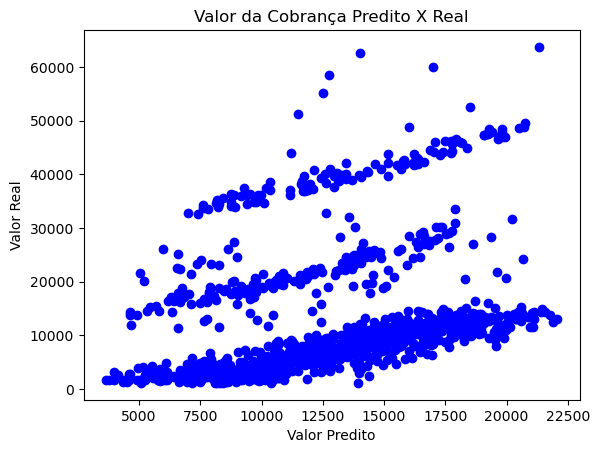

Compute Multiple Linear Regression: 0.67 segundos.


In [6]:
runMultipleLinearRegressionExample("insurance.csv")